In [1]:
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
from growth.sweep.sweep import Sweep
from clones.visualization.settings import *
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
figsize = (2, 2)
savedir = './graphics/synthetic_example/'
savefig = lambda fig, name: fig.savefig(join(savedir, '{:s}.pdf'.format(name)), dpi=400, 
                                        rasterized=True, transparent=True, bbox_inches='tight')

# Generate synthetic data

Load simulated bleedthrough control experiment and generate synthetic fluorescence data. Synthetic images contain three color channels:
   - BLUE: Nuclear stain
   - RED: Clonal marker
   - GREEN: Control reporter

In [3]:
sweep = Sweep.load('../../../data/synthetic/sweeps/Sweep_181201_191516/')
simulation = sweep[0]

In [4]:
# generate synthetic data

measurement_kwargs = dict(measurement_noise=0.)
microscopy_kwargs = dict(bg_level=0.2, bg_noise=0.3)

microscopy = simulation.generate_microscopy(ambiguity=0.2, rho=0.0, bleedthrough=0.5, 
                measurement_kwargs=measurement_kwargs, microscopy_kwargs=microscopy_kwargs)

# save synthetic data
#np.save('../../../data/synthetic/annotation_example/image.npy', microscopy.im)
#microscopy.data.to_hdf('../../../data/synthetic/annotation_example/data.hdf', key='microscopy')

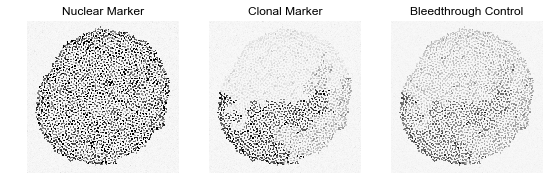

In [5]:
nuclear_marker = microscopy[0]
clonal_marker = microscopy[1]
control_reporter = microscopy[2]

fig = microscopy.render_panels(size=3)

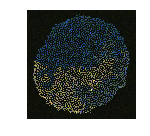

In [6]:
fig = microscopy.render(size=2)
savefig(fig, 'raw_image')

### Segment synthetic nuclei

This is just a sanity check. We will perform the annotation using the ground-truth measurements. In principle we could also benchmark the accuracy of our segmentation and fluorescence measurements, but image segmentation is so context dependent that we don't feel this is a meaningful exercise.

In [7]:
from clones.data.images import ImageScalar
from clones.measurement.segmentation import Segmentation
from clones.measurement.measure import Measurements

def find_nuclei(im, show=False):
    
    # construct and preprocess image
    image = ImageScalar(im)
    image.preprocess(median_radius=1, gaussian_sigma=(0.5, 0.5))
    
    # perform segmentation and exclude small segments
    seg = Segmentation(image, seed_kws=dict(sigma=0.5, min_distance=1))
    seg.exclude_small_segments(min_area=10)
    
    if show:
        _ = image.show()
        
    return seg

In [8]:
# detect nuclei and measure their intensities
segmentation = find_nuclei(nuclear_marker.im_normalized[0], show=False)
measurements = Measurements(microscopy.rgb_im, segmentation.labels).build_dataframe()
print(segmentation.num_objects, nuclear_marker.num_nuclei)

2107 2136


### Annotation

In [13]:
from clones.annotation.bayesian import BayesianClassifier
from clones.annotation.model_selection import ModelSelection

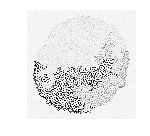

In [16]:
fig = clonal_marker.render(size=2, cmap=plt.cm.Greys)
#savefig(fig, 'clonal_marker')

# Fit mixture model

In [17]:
from clones.annotation.model_selection import ModelSelection

In [18]:
clonal_marker_levels = microscopy.data.clonal_marker.values

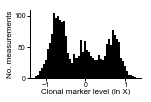

In [19]:
fig, ax = plt.subplots(figsize=(2, 1.25))
_ = ax.hist(np.log(clonal_marker_levels), bins=50, color='k')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('No. measurements')
ax.set_xlabel('Clonal marker level (ln X)')

savefig(fig, 'clonal_marker_histogram')

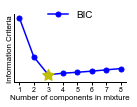

In [20]:
# model selection
selector = ModelSelection(clonal_marker_levels, classify_on='clonal_marker', min_num_components=1, max_num_components=8, crop=False)
fig = selector.plot_information_criteria(aic=False, figsize=(2, 1.25))

savefig(fig, 'model_selection')

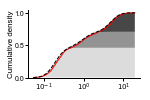

In [21]:
mixture_model = selector.BIC_optimal
fig = selector.BIC_optimal.plot_cdfs(log=True, cmap=plt.cm.Greys, alpha=1., figsize=(2, 1.25))
from matplotlib.ticker import ScalarFormatter
ax = fig.axes[0]
_ = ax.set_xticklabels(['$10^{{{:d}}}$'.format(int(x)) for x in ax.get_xticks()])

savefig(fig, 'model_fit')

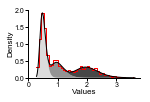

In [22]:
fig = mixture_model.stacked_pdfs(empirical=True, alpha=1., figsize=(2, 1.25))
ax = fig.axes[0]
ax.set_ylim(0, 2.0)

savefig(fig, 'model_fit_pdf')

# Define mapping

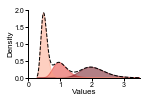

In [30]:
fig = mixture_model.plot_pdfs(empirical=False, alpha=0.5, cmap=plt.cm.Reds, figsize=(2, 1.25))
ax = fig.axes[0]
ax.set_ylim(0, 2.0)
ax.set_xlim(0, 3.5)

savefig(fig, 'pdf_mapping')

# Simple classifier

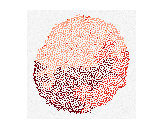

In [42]:
microscopy.data['simple'] = mixture_model(microscopy.data)

fig, ax = plt.subplots(figsize=figsize)
clonal_marker.render(ax=ax, cmap=plt.cm.Greys)
microscopy.render_mask('simple', cmap=plt.cm.Reds, vmin=-1, vmax=2, ax=ax)

savefig(fig, 'simple_classification')

# Annotation algorithm

In [31]:
# construct graph
from clones.spatial.graphs import WeightedGraph
graph = WeightedGraph(microscopy.data, weighted_by='clonal_marker', logratio=True)

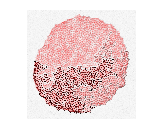

In [50]:
# create axis and add image
fig, ax = plt.subplots(figsize=figsize)
_ = clonal_marker.render(ax=ax, cmap=plt.cm.Greys)

# add graph
graph_kw = dict(node_size=0., node_color='r', node_alpha=0., 
                edge_color='r', lw=0.5, edge_alpha=0.5,
                colorby=None)

graph.show(ax=ax, **graph_kw)

savefig(fig, 'graph')

# Community annotation

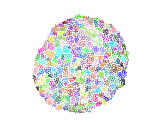

In [38]:
graph.find_communities()

# create axis and add image
fig, ax = plt.subplots(figsize=figsize)
#_ = clonal_marker.render(ax=ax, cmap='r')
clonal_marker.render_blank(ax=ax)

# add graph
graph_kw = dict(node_size=1., node_alpha=1.,
                lw=0.5, edge_alpha=1.)

graph.show(ax=ax, colorby='community', disconnect=True, **graph_kw)

savefig(fig, 'communities')

In [43]:
from clones.annotation.community import InfomapLabeler, KatzLabeler

# apply alternate labels
klabeler = KatzLabeler(graph, mixture_model, label='katz')
klabeler(microscopy.data)
ilabeler = InfomapLabeler(graph, mixture_model, label='infomap')
ilabeler(microscopy.data)

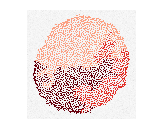

In [44]:
fig, ax = plt.subplots(figsize=figsize)
clonal_marker.render(ax=ax, cmap=plt.cm.Greys)
microscopy.render_mask('katz', cmap=plt.cm.Reds, vmin=-1, vmax=2, ax=ax)
savefig(fig, 'katz_labeled')

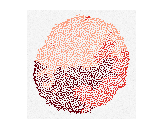

In [45]:
fig, ax = plt.subplots(figsize=figsize)
clonal_marker.render(ax=ax, cmap=plt.cm.Greys)
microscopy.render_mask('infomap', cmap=plt.cm.Reds, vmin=-1, vmax=2, ax=ax)
savefig(fig, 'infomap_labeled')

### Annotation accuracy scoring

In [46]:
from clones.validation.scoring import Scoring
kscore = Scoring(microscopy.data.true_dosage, microscopy.data.katz)
iscore = Scoring(microscopy.data.true_dosage, microscopy.data.infomap)
sscore = Scoring(microscopy.data.true_dosage, microscopy.data.simple)

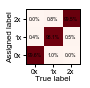

In [47]:
kscore.plot_matrix(text='rates', figsize=(1,1), fontsize=5)
savefig(kscore.matrix.fig, 'scores_katz')

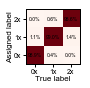

In [48]:
iscore.plot_matrix(text='rates', figsize=(1,1), fontsize=5)
savefig(iscore.matrix.fig, 'scores_imap')

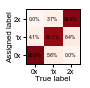

In [49]:
sscore.plot_matrix(text='rates', figsize=(1,1), fontsize=5)
savefig(sscore.matrix.fig, 'scores_simple')